In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# A function to load and preprocess an image
def load_image(image_path, max_dim=512):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img


In [3]:
# Function to display an image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = np.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)


In [4]:
# Function to create the VGG model
def create_model(layer_names):
    vgg_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg_model.trainable = False
    outputs = [vgg_model.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg_model.input], outputs)
    return model


In [5]:
# Function to calculate the gram matrix
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations


In [6]:
# Class for the style transfer model
class StyleTransferModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleTransferModel, self).__init__()
        self.vgg = create_model(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)

        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(layer) for layer in style_outputs]

        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [7]:
# Function to calculate the total loss
def total_loss(outputs, style_targets, content_targets, style_weights, style_weight, content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([style_weights[name] * tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)

    loss = style_loss + content_loss
    return loss


In [8]:
# Function to perform a training step
def train_step(image, extractor, style_targets, content_targets, style_weights, style_weight, content_weight):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = total_loss(outputs, style_targets, content_targets, style_weights, style_weight, content_weight)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [9]:
# Function to clip pixel values between 0 and 1
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


In [10]:
# Function to display the generated images
def display_generated_images(content_img, style_img, generated_img, iteration):
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    imshow(content_img, 'Content Image')
    plt.subplot(1, 3, 2)
    imshow(style_img, 'Style Image')
    plt.subplot(1, 3, 3)
    imshow(generated_img, f'Generated Image - Iteration {iteration}')
    plt.show()

In [31]:
# Function to perform style transfer on a folder of content images and a folder of style images
def perform_style_transfer(content_folder, style_folder):
    content_images = [os.path.join(content_folder, file) for file in os.listdir(content_folder) if file.endswith(('.jpg', '.png'))]
    style_images = [os.path.join(style_folder, file) for file in os.listdir(style_folder) if file.endswith(('.jpg', '.png'))]

    for content_path in content_images:
        content_img = load_image(content_path)
        for style_path in style_images:
            style_img = load_image(style_path)

            # Create the model and extract style and content targets
            extractor = StyleTransferModel(style_layers, content_layers)
            style_targets = extractor(style_img)['style']
            content_targets = extractor(content_img)['content']

            # Initialize the image to optimize
            generate_image = tf.Variable(content_img)

            # Perform style transfer and display images
            num_iterations = 300
            display_interval = num_iterations // 5
            for i in range(num_iterations):
                train_step(generate_image, extractor, style_targets, content_targets, style_weights, style_weight, content_weight)
                if i % display_interval == 0:
                    display_generated_images(content_img, style_img, generate_image.numpy(), i)

In [32]:
# Define the content and style layers
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# Custom weights for different style layers
style_weights = {'block1_conv1': 0.2, 'block2_conv1': 0.19, 'block3_conv1': 0.24, 'block4_conv1': 0.11, 'block5_conv1': 0.26}

# Define the style and content weights
style_weight = 40
content_weight = 10


In [33]:
# Define the optimizer
opt = tf.compat.v1.train.AdamOptimizer(learning_rate=0.02, beta1=0.99, epsilon=1e-1)


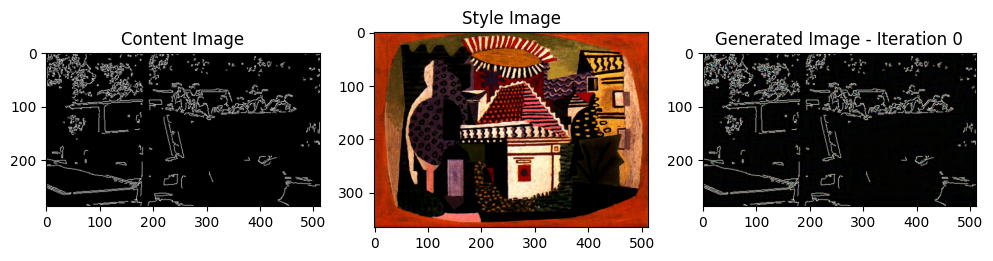

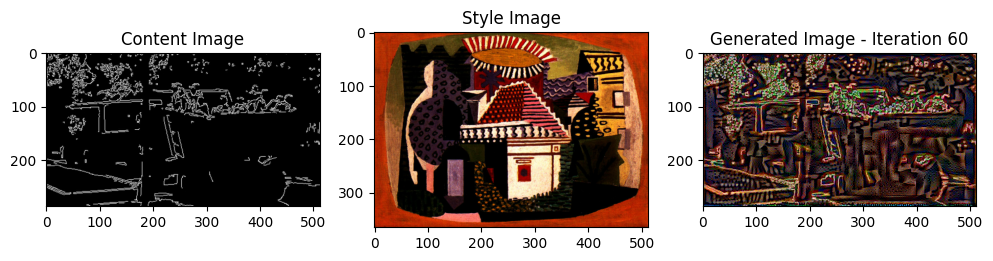

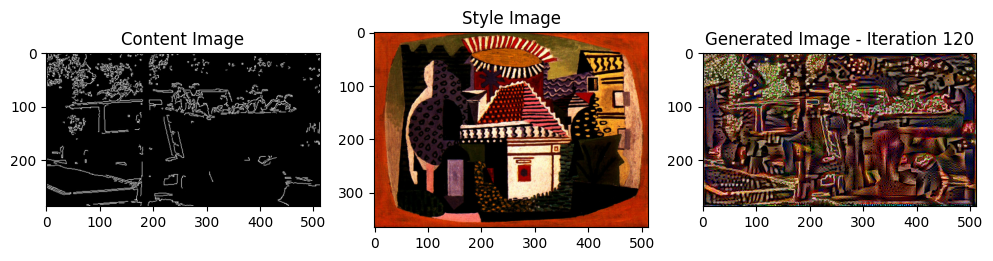

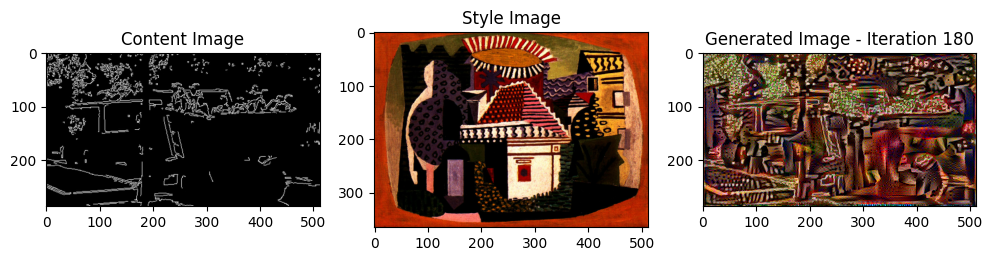

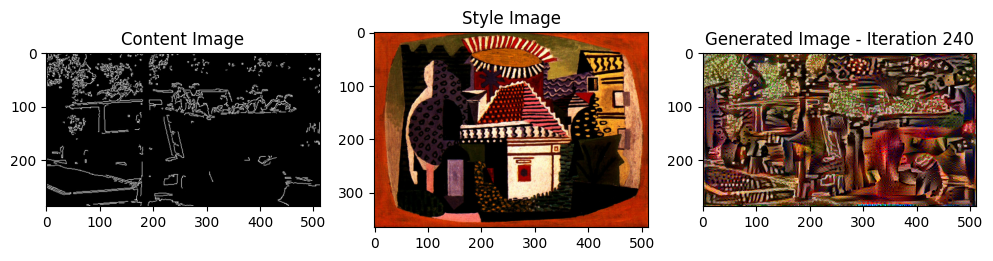

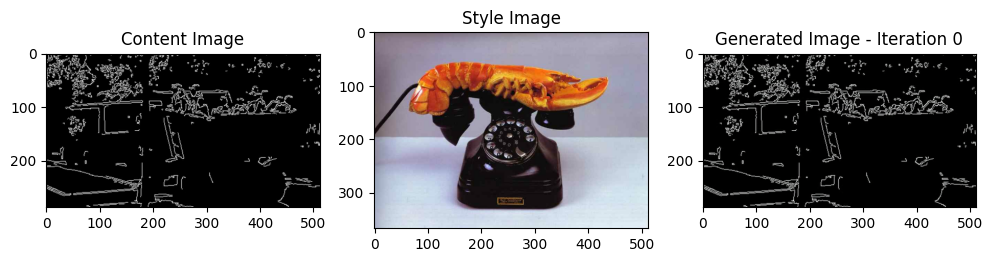

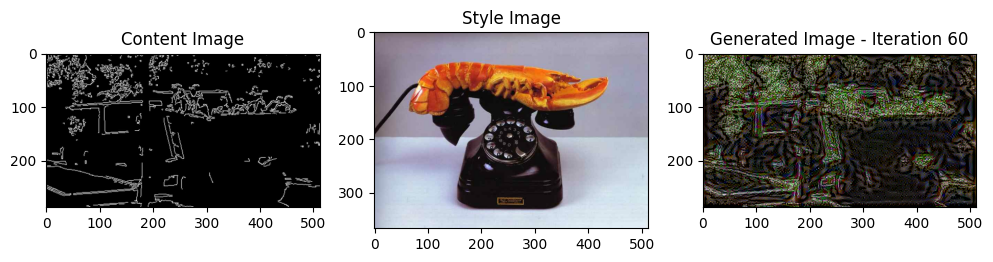

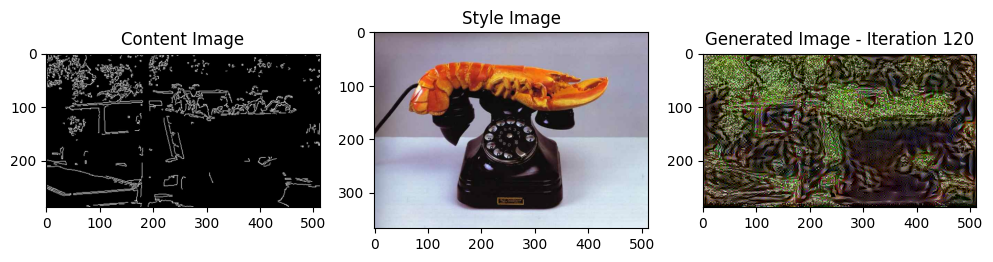

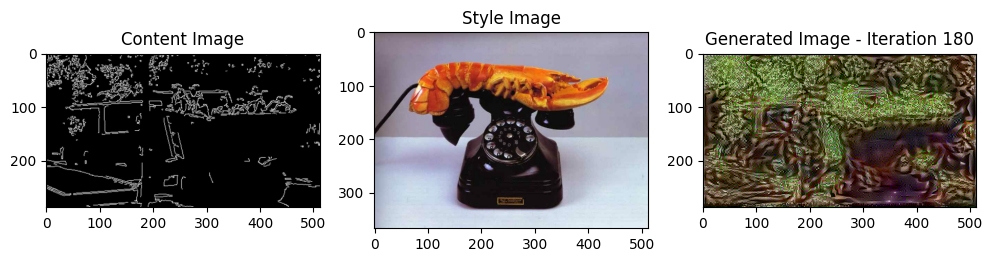

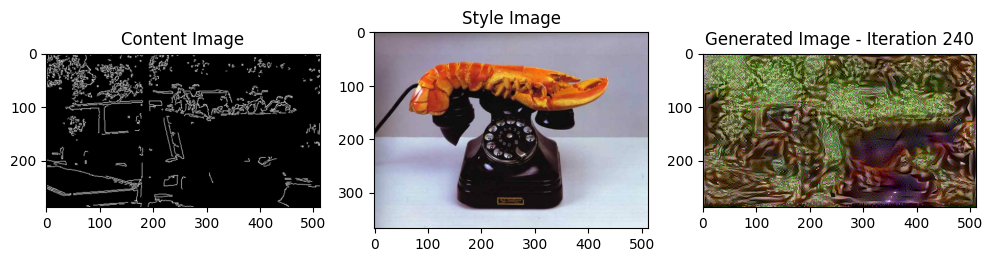

In [ ]:

# Specify the folders for content images and style images
content_folder = '/kaggle/input/satrry-night2/starry_night_coco/testA'
style_folder = '/kaggle/input/subwikiarts/imgs'

# Perform style transfer on the specified folders
perform_style_transfer(content_folder, style_folder)
